# Machine learning pipeline for modelling fraction of precipitation in different intensity bands

This notebook is designed to be run in AzureML 

### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# %load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [5]:
import prd_pipeline

In [6]:
import sys
# pathlib.Path.cwd().parent
sys.path.append('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-fractions/code/Users/hannah.brown/precip_rediagnosis/data_prep')
import drivers

Set up MLops for experiment tracking in AzureML

In [7]:
import mlflow
mlflow.tensorflow.autolog()

In [8]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [9]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

### Load and preprocess data

In [10]:
prd_merged_file_dataset_name = 'prd_merged_all_events_files'
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [11]:
target_parameter = [
    'radar_fraction_in_band_instant_0.0', 
    'radar_fraction_in_band_instant_0.25', 
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction'] #'air_pressure','cloud_volume_fraction',
single_lvl_features = [] #['surface_altitude']#,'air_pressure_at_sea_level','cloud_area_fraction']#'thickness_of_rainfall_amount']#] 

In [12]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [13]:
train202208_dataset_all = azureml.core.Dataset.get_by_name(prd_ws, name=prd_merged_file_dataset_name)
with train202208_dataset_all.mount() as mount1:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(mount1.mount_point).rglob('*csv') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list], ignore_index=True)

Not mounting as a volume: ArgumentError(InvalidArgument { argument: "arguments.path", expected: "Glob patterns inside the path are not supported by the volume mount.Path must be a direct path to the file or folder, or end with '/**' or '/**/*' to match the entire content of the volume.", actual: "REDACTED" }). 
Falling back to dataflow mount.
loading all data
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (urllib3 1.26.10 (/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages), Requirement.parse('urllib3<=1.26.9,>=1.23')).


In [14]:
target_parameter[0]

'radar_fraction_in_band_instant_0.0'

In [15]:
merged_df.shape

(2776212, 227)

In [16]:
tmp = merged_df[(merged_df.latitude==merged_df.latitude[0]) & (merged_df.longitude==merged_df.longitude[0]) & (merged_df.forecast_reference_time==merged_df.forecast_reference_time[0])]

In [17]:
sum(tmp['rainfall_rate']<0.25) / tmp.shape[0]

0.7777777777777778

In [18]:
merged_df[merged_df[target_parameter[0]]==1].shape

(1455642, 227)

### Calculate u and v wind fields and add column to dataset <i>- to be moved into data prep </i>

Adding columns with u and v wind fields

In [17]:
import math

wdir_columns = prd_pipeline.get_profile_columns(['wind_from_direction'], merged_df.columns)
ws_columns = prd_pipeline.get_profile_columns(['wind_speed'], merged_df.columns)

for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.sin(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']
    merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.cos(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']

5.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


10.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


20.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


30.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


50.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


75.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


100.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


150.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


200.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


250.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


300.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


400.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


600.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


700.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


800.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1250.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1750.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2250.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2750.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3250.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3750.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


4000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


4500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


5000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


5500.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


6000.0


/tmp/ipykernel_34461/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_34461/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


To check the u and v wind conversion, we convert back from u and v wind fields to wind speed and direction and compare this to wind speed and direction in the dataset. This test currently fails as there are a few data points with wind speeds of zero. May be worth some investigation into whether these zero are spurious or not, but perhaps easiest at this stage to filter out zero values. 

In [18]:
# test for u and v wind conversion
for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    print(merged_df[(merged_df[f'wind_from_direction_{height_level}'] != np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4))][[f'wind_from_direction_{height_level}', f'wind_speed_{height_level}']])
    merged_df = merged_df[merged_df[ws] != 0]
    
    assert (merged_df[f'wind_speed_{height_level}'] == np.round(np.sqrt(merged_df[f'u_wind_{height_level}']**2 + merged_df[f'v_wind_{height_level}']**2),4)).all()
    assert (merged_df[f'wind_from_direction_{height_level}'] == np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4)).all()

5.0
Empty DataFrame
Columns: [wind_from_direction_5.0, wind_speed_5.0]
Index: []
10.0
Empty DataFrame
Columns: [wind_from_direction_10.0, wind_speed_10.0]
Index: []
20.0
        wind_from_direction_20.0  wind_speed_20.0
15384                   120.9375              0.0
46116                   167.9375              0.0
47130                   240.5625              0.0
236583                  186.9375              0.0
284608                  244.8125              0.0
30.0
        wind_from_direction_30.0  wind_speed_30.0
20839                    45.0000              0.0
24323                   135.0000              0.0
24324                   153.4375              0.0
24870                   243.4375              0.0
206348                  135.0000              0.0
16801                    60.8125              0.0
44612                   312.2500              0.0
44709                   331.3125              0.0
128175                   90.0000              0.0
154882                  2

### Data pre-processing

Split train, test and validate datasets

In [19]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

target has dims: 5
dropping smallest bin: radar_fraction_in_band_instant_0.0
getting profile columns
{'nprof_features': 4, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


In [21]:
data_splits['X_train'].shape

(792484, 33, 4)

### Plot pie charts of average fractions in bands

Make a copy of the training dataset and add a column which contains the label for the intensity band with the highest fraction

In [18]:
tmp = data_splits['y_train'].copy().reset_index(drop=True)
tmp['max_bin'] = tmp.idxmax(axis=1)
tmp[tmp['max_bin']==feature_dict['target'][-1]]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,max_bin
47880,0.0,0.11358,0.330864,0.209877,0.355556,radar_fraction_in_band_instant_10.0
47881,0.0,0.11358,0.330864,0.209877,0.355556,radar_fraction_in_band_instant_10.0
47882,0.0,0.11358,0.330864,0.209877,0.355556,radar_fraction_in_band_instant_10.0
47883,0.0,0.11358,0.330864,0.209877,0.355556,radar_fraction_in_band_instant_10.0
47884,0.0,0.11358,0.330864,0.209877,0.355556,radar_fraction_in_band_instant_10.0
...,...,...,...,...,...,...
586437,0.0,0.00000,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
586438,0.0,0.00000,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
586439,0.0,0.00000,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
586440,0.0,0.00000,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0


Plot a pie chart of counts of the different intensity bands having highest fraction

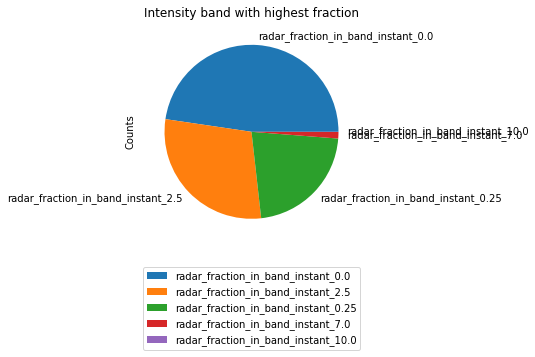

In [19]:
avg_df = pd.DataFrame({'Counts': tmp['max_bin'].value_counts()})
avg_df.plot.pie(subplots=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.title('Intensity band with highest fraction')
plt.show()

In [21]:
def pie_chart_mean_fractions_in_bands(df, title):
    """Calculates the average values of a pandas series provided and produces a pie chart"""
    avg_df = pd.DataFrame({'Average': df.mean()})
    avg_df.plot.pie(subplots=True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.title(title)
    plt.show()

Produce pie chart for the average fraction in each intensity band for the train, test and validate datasets

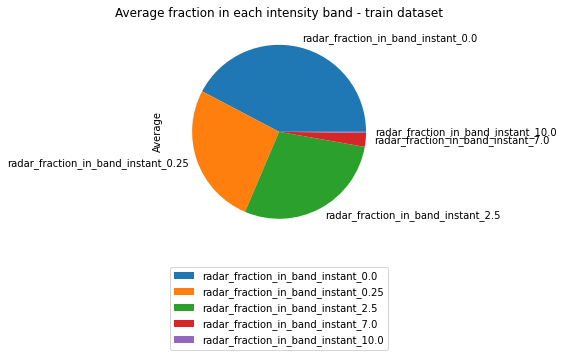

In [22]:
pie_chart_mean_fractions_in_bands(data_splits['y_train'], title='Average fraction in each intensity band - train dataset')

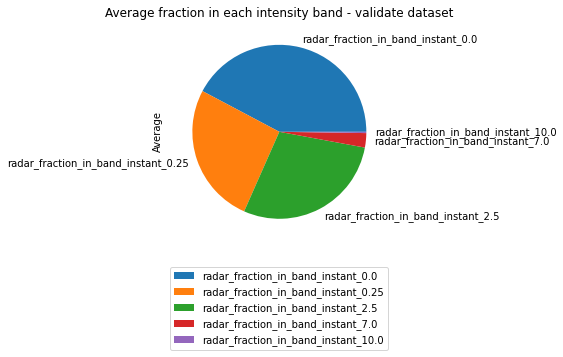

In [23]:
pie_chart_mean_fractions_in_bands(data_splits['y_val'], title='Average fraction in each intensity band - validate dataset')

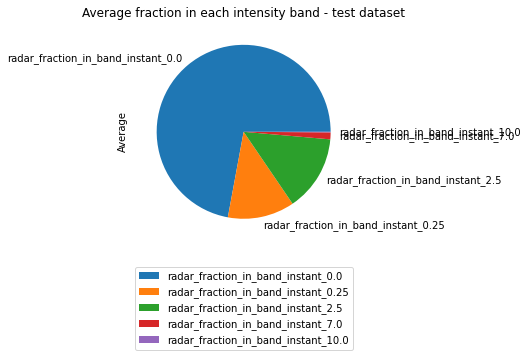

In [24]:
pie_chart_mean_fractions_in_bands(df_test[target_parameter], title='Average fraction in each intensity band - test dataset')

<AxesSubplot:>

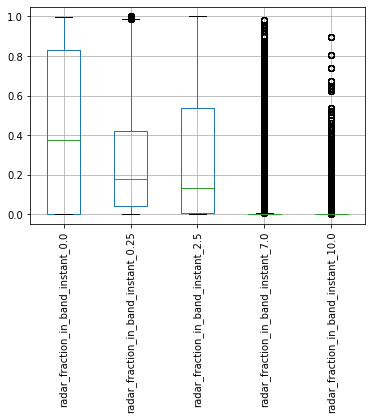

In [19]:
data_splits['y_train'].boxplot(rot=90)

<AxesSubplot:>

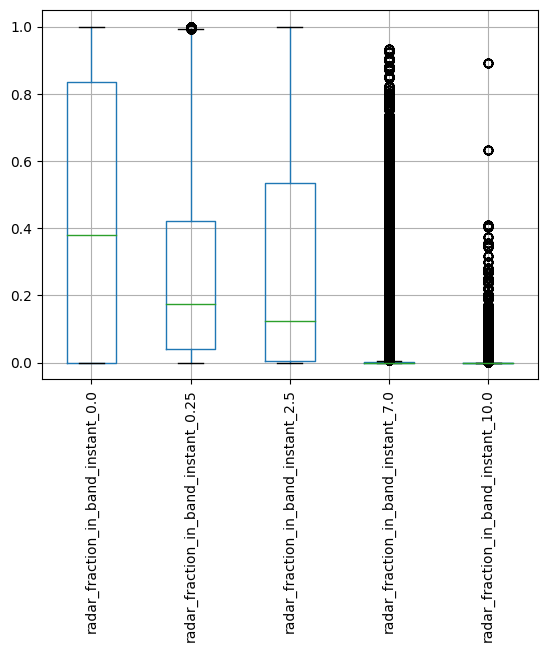

In [20]:
data_splits['y_val'].boxplot(rot=90)

<AxesSubplot:>

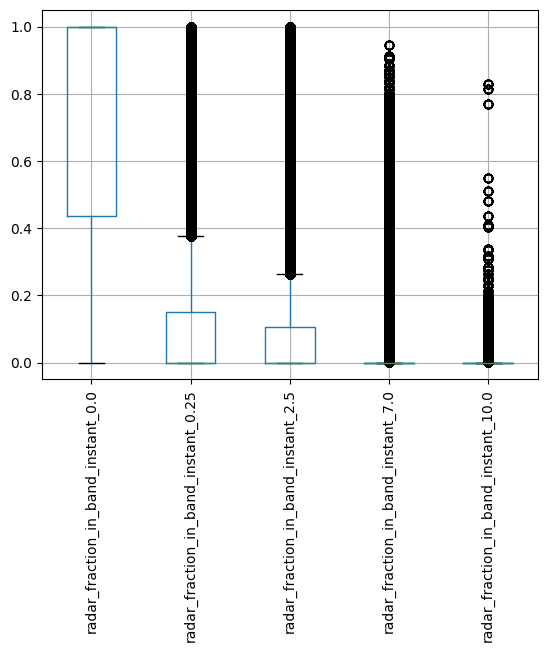

In [21]:
df_test[target_parameter].boxplot(rot=90)

For each intensity band, select a subset which contains datapoint where the highest fraction falls into that intensity band, then produce the pie chart showing this average fraction in each intensity band. This allows us to see whether on average when a band has highest fraction whether it is marginally highest or is much higher than fractions of other bands.

/tmp/ipykernel_13384/1970291782.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_df = pd.DataFrame({'Average': df.mean()})


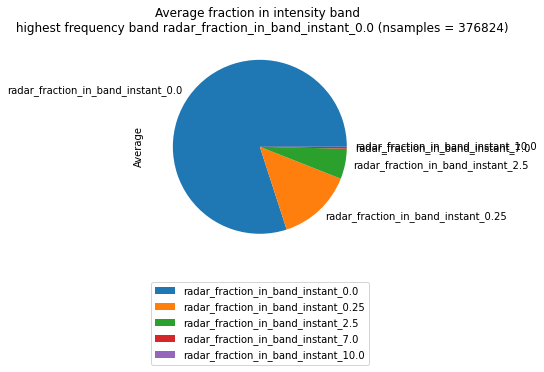

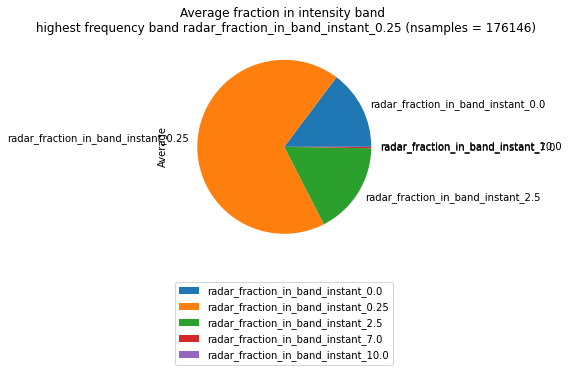

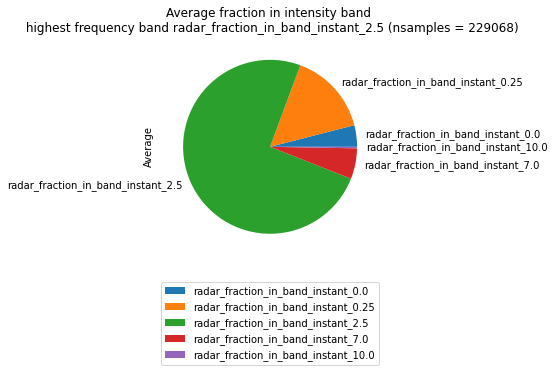

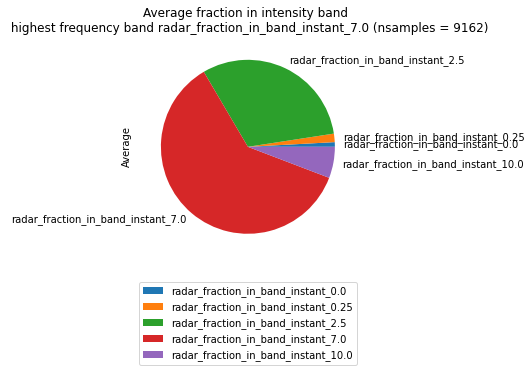

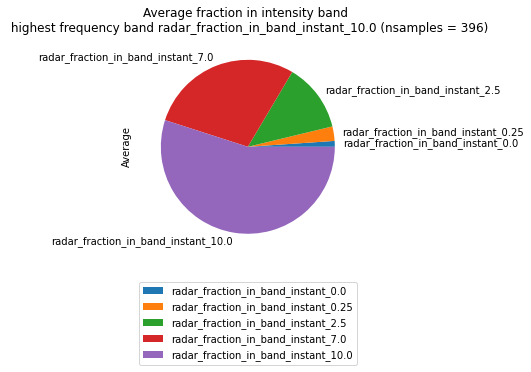

In [30]:
tmp = tmp.reset_index(drop=True)
for col in tmp.columns[:-1]:
    subset = tmp[tmp['max_bin']==col]
    pie_chart_mean_fractions_in_bands(subset, title=f'Average fraction in intensity band \n highest frequency band {col} (nsamples = {len(subset)})')
    plt.show()

### Resample data

Resample data to create more uniform distribution within the training data

In [22]:
tmp = data_splits['y_train'].copy()
tmp['max_bin'] = tmp.idxmax(axis=1)

In [29]:
tmp['max_bin'].value_counts()

radar_fraction_in_band_instant_0.0     377568
radar_fraction_in_band_instant_2.5     231748
radar_fraction_in_band_instant_0.25    173466
radar_fraction_in_band_instant_7.0       9324
radar_fraction_in_band_instant_10.0       378
Name: max_bin, dtype: int64

In [28]:
data_splits['y_train'][data_splits['y_train']['radar_fraction_in_band_instant_7.0']>0.1]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
3924,0.228571,0.37381,0.219048,0.135714,0.047619
3925,0.228571,0.37381,0.219048,0.135714,0.047619
3926,0.228571,0.37381,0.219048,0.135714,0.047619
3927,0.228571,0.37381,0.219048,0.135714,0.047619
3928,0.228571,0.37381,0.219048,0.135714,0.047619
...,...,...,...,...,...
1052975,0.077694,0.20802,0.526316,0.205514,0.000000
1052976,0.077694,0.20802,0.526316,0.205514,0.000000
1052977,0.077694,0.20802,0.526316,0.205514,0.000000
1052978,0.077694,0.20802,0.526316,0.205514,0.000000


In [23]:
data_splits['y_train'].mean()

radar_fraction_in_band_instant_0.0     0.425708
radar_fraction_in_band_instant_0.25    0.264659
radar_fraction_in_band_instant_2.5     0.291568
radar_fraction_in_band_instant_7.0     0.025930
radar_fraction_in_band_instant_10.0    0.002112
dtype: float64

In [24]:
# weights = 1 / (tmp['max_bin'].value_counts() / tmp.shape[0]) / 4
weights = 1 / data_splits['y_train'].mean() / 10
weights = weights.reset_index(drop=True).to_dict()
weights

{0: 0.23490262962687475,
 1: 0.3778445204994035,
 2: 0.34297316816768586,
 3: 3.8564879284739133,
 4: 47.35808708952}

In [30]:
# nsamples = len(tmp)//len(tmp.columns)
# print('n samples =', nsamples)

# y_train = pd.DataFrame()

# tmp = tmp.reset_index(drop=True)

# for col in tmp.columns[0:-1]:
#     print(col)
#     ids = tmp[tmp['max_bin']==col].index
#     print(ids.shape)
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, tmp.loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

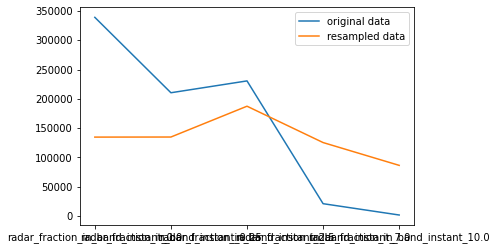

In [28]:
# cols = data_splits['y_train'].columns
# plt.plot(data_splits['y_train'].sum(axis=0), label='original data')
# plt.plot(y_train[cols].sum(axis=0), label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

In [31]:
# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [25]:
exp_name='prd_fraction_models_mlflow'
exp1 = mlflow.create_experiment(exp_name)
exp1

'27014deb-848c-4241-966e-55b80a0c8ed4'

In [26]:
exp1 = mlflow.get_experiment(exp1)
exp1

<Experiment: artifact_location='', experiment_id='27014deb-848c-4241-966e-55b80a0c8ed4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

In [27]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64, 
    'class_weights': weights
}

In [28]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 4)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 4)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       384         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-10-04 15:38:39.078394: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-04 15:38:39.078480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prd-ml-fractions): /proc/driver/nvidia/version does not exist
2022-10-04 15:38:39.080530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
12386/12386 [==============================] - 56s 4ms/step - loss: 0.2083 - accuracy: 0.5884 - val_loss: 0.6069 - val_accuracy: 0.5609
Epoch 2/10
12386/12386 [==============================] - 55s 4ms/step - loss: 0.1831 - accuracy: 0.6093 - val_loss: 0.4811 - val_accuracy: 0.6136
Epoch 3/10
12386/12386 [==============================] - 55s 4ms/step - loss: 0.1733 - accuracy: 0.6183 - val_loss: 0.4879 - val_accuracy: 0.6088
Epoch 4/10
12386/12386 [==============================] - 55s 4ms/step - loss: 0.1678 - accuracy: 0.6242 - val_loss: 0.4709 - val_accuracy: 0.6206
Epoch 5/10
12386/12386 [==============================] - 55s 4ms/step - loss: 0.1621 - accuracy: 0.6300 - val_loss: 0.4473 - val_accuracy: 0.6322
Epoch 6/10
12386/12386 [==============================] - 56s 5ms/step - loss: 0.1586 - accuracy: 0.6342 - val_loss: 0.4374 - val_accuracy: 0.6394
Epoch 7/10
12386/12386 [==============================] - 55s 4ms/step - loss: 0.1542 - accuracy: 0.6393 - val_loss: 0

INFO:tensorflow:Assets written to: /tmp/tmpgqs4txg2/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpgqs4txg2/model/data/model/assets
2022/10/04 15:47:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."
2022/10/04 15:49:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: AzureMLException:
	Message: Failed to flush task queue within 120 seconds
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Failed to flush task queue within 120 seconds",
        "inner_error": {
            "code": "ResourceExhausted",
            "inner_error": {
                "code": "Timeout"
            }
        }
    }
}


In [29]:
history.history

{'loss': [0.20830102264881134,
  0.18314842879772186,
  0.17331402003765106,
  0.16776694357395172,
  0.16205035150051117,
  0.158638134598732,
  0.15421141684055328,
  0.1520785391330719,
  0.14923547208309174,
  0.1472313553094864],
 'accuracy': [0.5883798599243164,
  0.6093384623527527,
  0.6183272004127502,
  0.6242212653160095,
  0.6299602389335632,
  0.6341650485992432,
  0.6392744183540344,
  0.6424548625946045,
  0.6464377045631409,
  0.6484032273292542],
 'val_loss': [0.6068567037582397,
  0.48112860321998596,
  0.48790186643600464,
  0.47085320949554443,
  0.4472751319408417,
  0.4374273419380188,
  0.4289204180240631,
  0.4409453868865967,
  0.4856477379798889,
  0.4428209662437439],
 'val_accuracy': [0.5608590245246887,
  0.6136246919631958,
  0.608805775642395,
  0.6206467151641846,
  0.6321583390235901,
  0.6393582820892334,
  0.6432573199272156,
  0.6375601887702942,
  0.6195489168167114,
  0.6353078484535217]}

### Feature importance

Here we calculate the Breiman permutation importance for each of the model input features. This allows us to assess how much information each input feature is contributing to the resulting predictions from the ML model. 

 - At each step, only one predictor is permuted (randomized)
 - The amount by which the loss function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the loss function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the loss function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the loss function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [31]:
feature_names = feature_dict['profile'] + feature_dict['single_level']

In [32]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 5

original_metric = history.history['val_loss'][-1]

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        if data_dims_dict['nsinglvl_features'] > 0:
            X_val_permute = [data_splits['X_val'][0].copy(), data_splits['X_val'][1].copy()]
            if feature in feature_dict['single_level']:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = data_splits['X_val'].copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        
        permuted_metric = tf.keras.metrics.KLDivergence()
        permuted_metric.update_state(data_splits['y_val'], y_pred)
        permuted_metric = permuted_metric.result().numpy()
        
        permutation_importance[feature].append(permuted_metric - original_metric)

permuting feature: air_temperature
8241/8241 [==============================] - 12s 1ms/step
permuting feature: relative_humidity
8241/8241 [==============================] - 12s 1ms/step
permuting feature: wind_speed
8241/8241 [==============================] - 12s 1ms/step
permuting feature: wind_from_direction
8241/8241 [==============================] - 12s 1ms/step


In [36]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.37919480800628663, 'relative_humidity': 0.29138520956039426, 'wind_speed': 0.212924325466156, 'wind_from_direction': 0.2638593912124634}


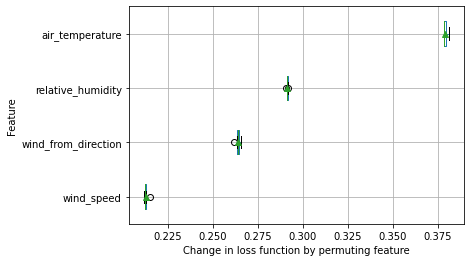

In [37]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

In [38]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.37919480800628663, 'relative_humidity': 0.29138520956039426, 'wind_speed': 0.212924325466156, 'wind_from_direction': 0.2638593912124634}


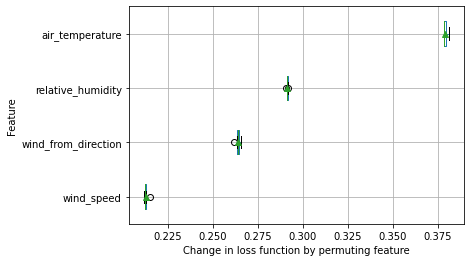

In [39]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

### Model evaluation

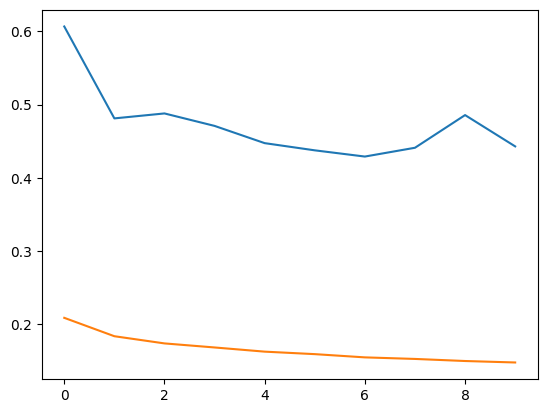

In [30]:
plt.plot(range(10),history.history['val_loss'])
plt.plot(range(10), history.history['loss'])

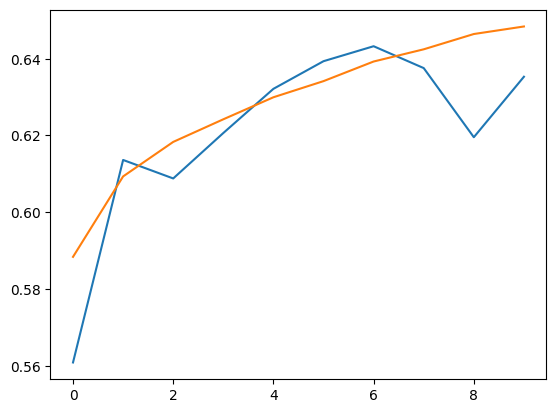

In [31]:
plt.plot(range(10), history.history['val_accuracy'])
plt.plot(range(10), history.history['accuracy'])

In [32]:
y_pred = model.predict(data_splits['X_val'])

8256/8256 [==============================] - 13s 2ms/step


TO DO: overlay corresponding MOGREPS-G output

In [33]:
data_splits['y_train']

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0.875587,0.124413,0.000000,0.0,0.0
1,0.875587,0.124413,0.000000,0.0,0.0
2,0.875587,0.124413,0.000000,0.0,0.0
3,0.875587,0.124413,0.000000,0.0,0.0
4,0.875587,0.124413,0.000000,0.0,0.0
...,...,...,...,...,...
1056821,0.925595,0.023810,0.056548,0.0,0.0
1056822,0.925595,0.023810,0.056548,0.0,0.0
1056823,0.925595,0.023810,0.056548,0.0,0.0
1056824,0.925595,0.023810,0.056548,0.0,0.0


In [41]:
merged_df

,rainfall_rate,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0.000000,0.463529,0.515294,0.025882,0.0,0.0
1,0.536442,0.463529,0.515294,0.025882,0.0,0.0
2,0.000000,0.463529,0.515294,0.025882,0.0,0.0
3,0.000000,0.463529,0.515294,0.025882,0.0,0.0
4,0.000000,0.463529,0.515294,0.025882,0.0,0.0
...,...,...,...,...,...,...
2776207,0.000000,1.000000,0.000000,0.000000,0.0,0.0
2776208,0.000000,1.000000,0.000000,0.000000,0.0,0.0
2776209,0.013411,1.000000,0.000000,0.000000,0.0,0.0
2776210,0.000000,1.000000,0.000000,0.000000,0.0,0.0


In [44]:
pd.merge(merged_df[['rainfall_rate'] + target_parameter], data_splits['y_train'], left_on=target_parameter, right_on=target_parameter)

TypeError: merge() got an unexpected keyword argument 'axis'

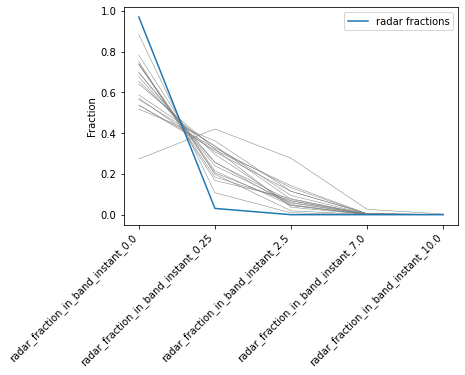

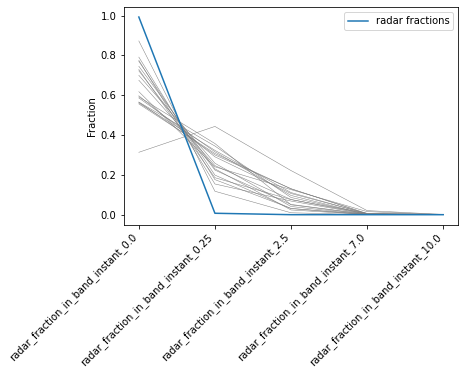

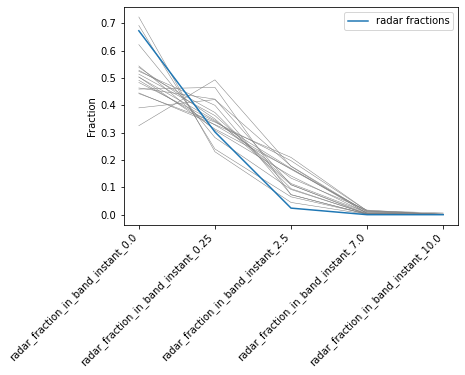

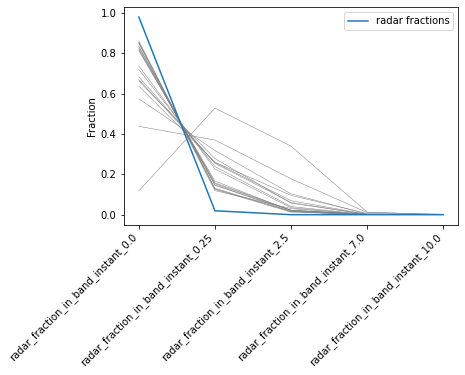

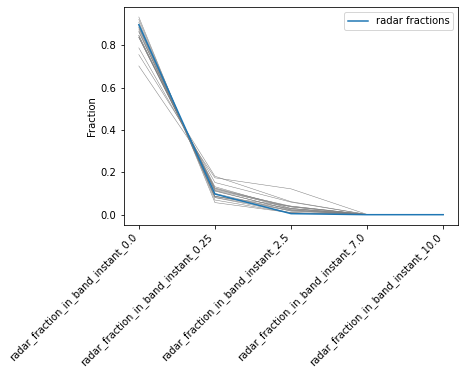

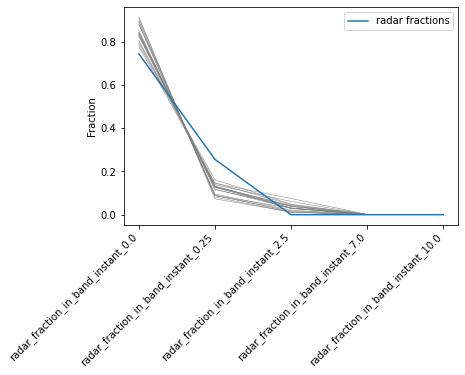

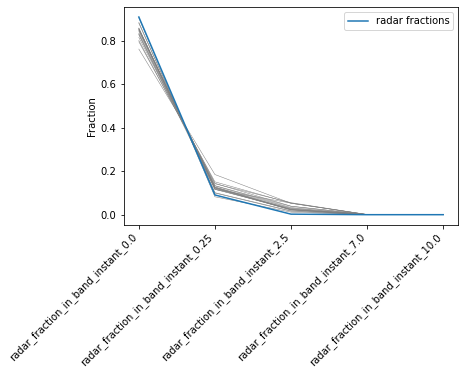

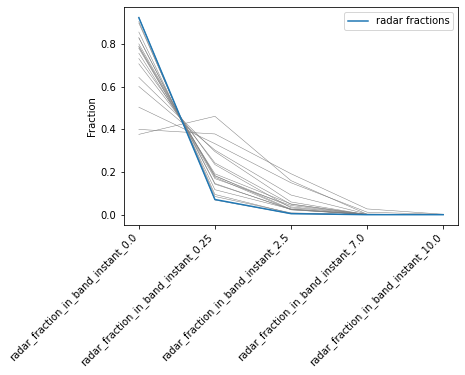

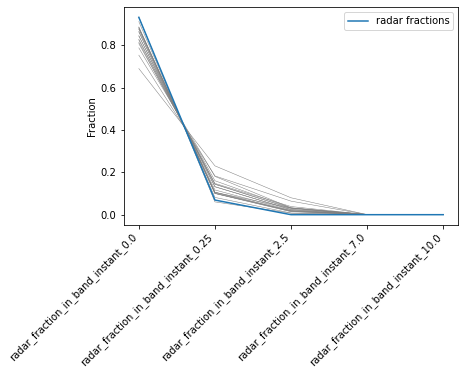

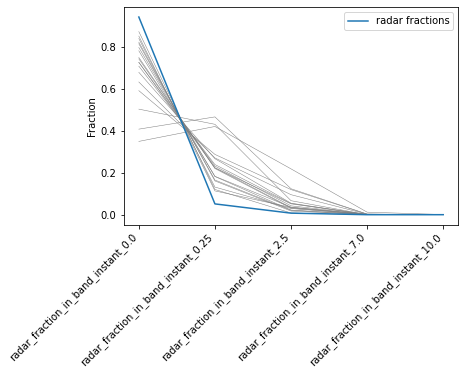

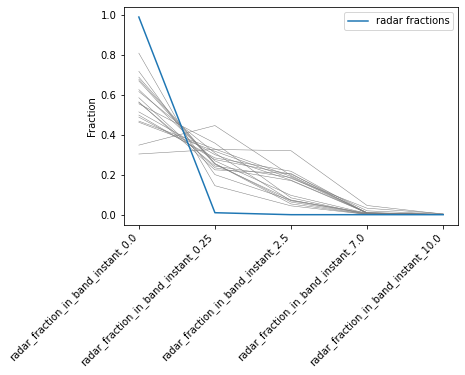

In [70]:
for loc in np.arange(0,181,18):
    for member in np.arange(18):
        plt.plot(y_pred[loc+member], lw=0.5, color='grey')
    plt.plot(data_splits['y_val'].iloc[loc+member], label='radar fractions')
    plt.ylabel('Fraction')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

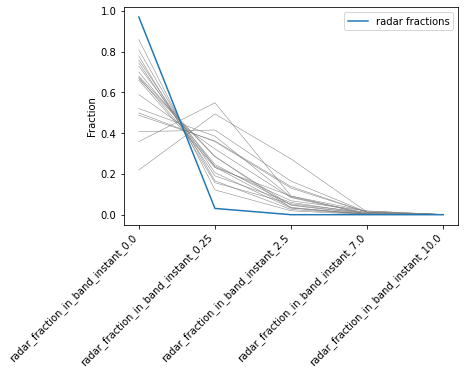

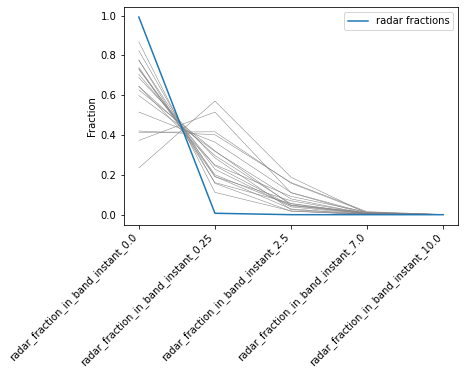

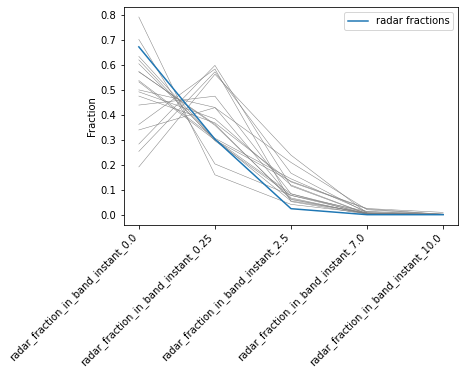

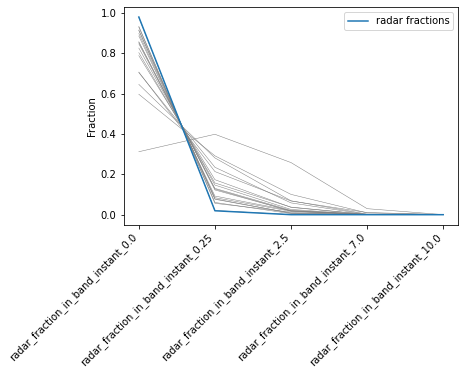

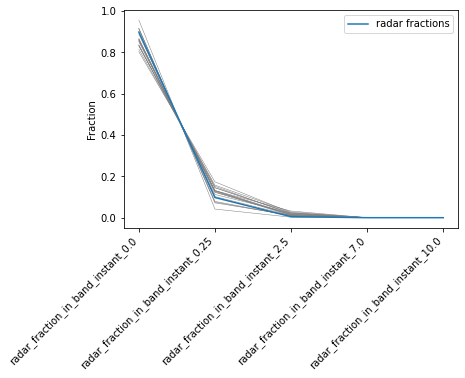

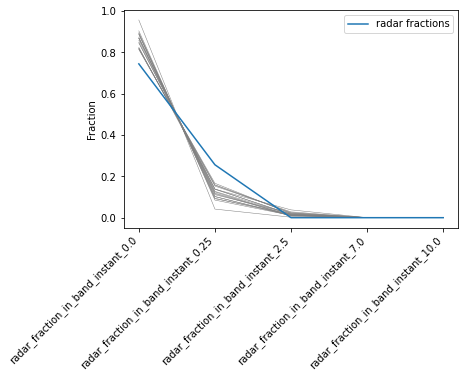

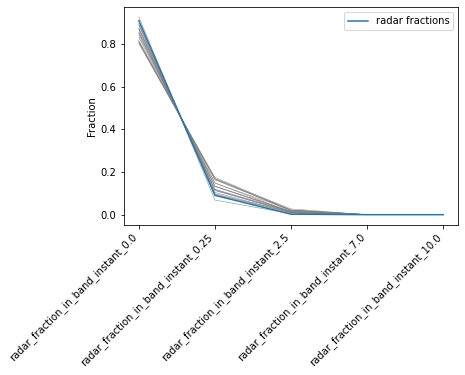

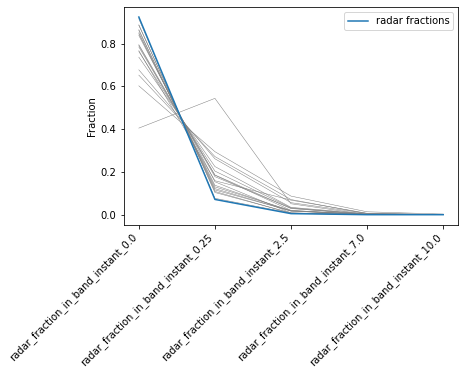

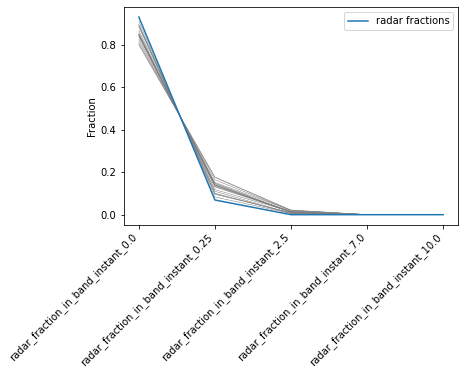

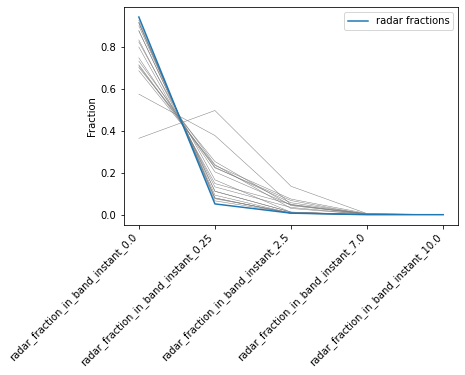

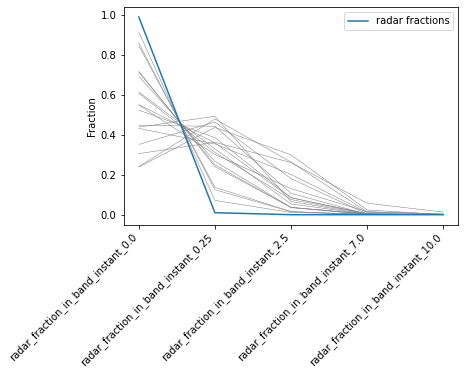

In [35]:
for loc in np.arange(0,181,18):
    for member in np.arange(18):
        plt.plot(y_pred[loc+member], lw=0.5, color='grey')
    plt.plot(data_splits['y_val'].iloc[loc+member], label='radar fractions')
    plt.ylabel('Fraction')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

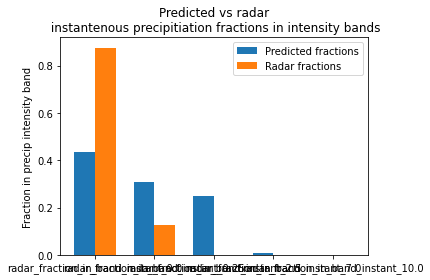

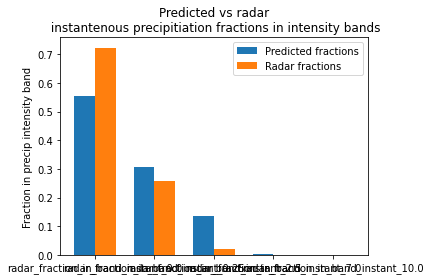

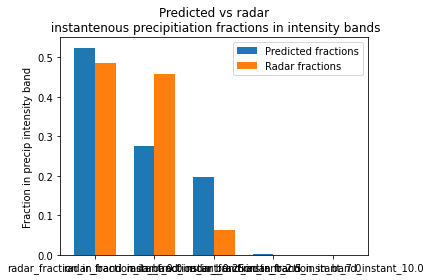

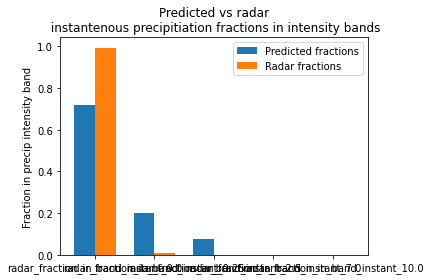

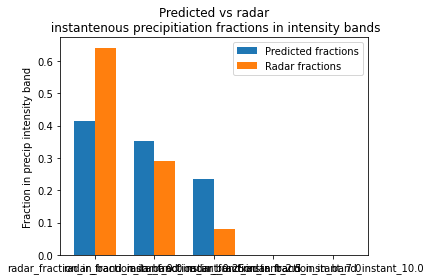

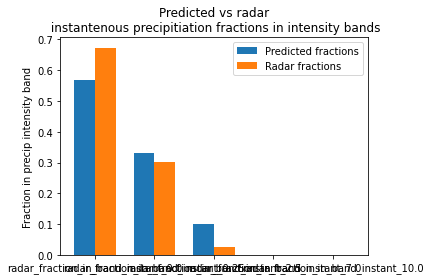

In [44]:
for loc in np.arange(0,91,18):
    x = np.arange(len(target_parameter))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_pred[loc], width, label='Predicted fractions')
    rects2 = ax.bar(x + width/2, data_splits['y_val'].iloc[loc], width, label='Radar fractions')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction in precip intensity band')
    ax.set_title('Predicted vs radar\n instantenous precipitiation fractions in intensity bands')
    ax.set_xticks(x, target_parameter)
    ax.legend()

    fig.tight_layout()

    plt.show()
    # plt.bar(y_pred[loc], label='prediction')
    # plt.bar(data_splits['y_val'].iloc[loc], label='target')
    # plt.legend()
    # plt.show()

Fractional skill score

In [59]:
# non-cumulative i.e. assessing the FSS of specific bands individually
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,i] - data_splits['y_val'][col])**2
    FBS_ref = y_pred[:,i]**2 + data_splits['y_val'][col]**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.5595233369916855
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.626678880612667
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.5364230984009078
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.1449651352215521
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.02296390065334317


In [36]:
# cumulative
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,:i+1].sum(axis=1) - data_splits['y_val'][cols[:i+1]].sum(axis=1))**2
    FBS_ref = y_pred[:,:i+1].sum(axis=1)**2 + data_splits['y_val'][cols[:i+1]].sum(axis=1)**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.529233904490115
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.7755793102774847
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.9691843007353734
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.9976080638288336
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.9998412095852618
